In [371]:
import os
import sys

import pandas as pd
import numpy as np

import seaborn as sns

from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from torch.autograd import Variable
import torchvision.transforms as T
from torchsummary import summary
import torch.nn.functional as F
# MAKE SURE TO SHUFFLE IMPORT ORDER AND DELETE USELESS IMPORTS
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, Dropout, BatchNorm2d, BCELoss
from torch.optim import Adam, SGD

In [2]:
# Data Directories
clothmask = "F:\Libraries\Documents\ALL\School\GrDip\comp6721_applied_artificial_intelligence\project\FaceMaskCNN\data\masktype\Dataset\ClothMask"
ffp2mask = "F:\Libraries\Documents\ALL\School\GrDip\comp6721_applied_artificial_intelligence\project\FaceMaskCNN\data\masktype\Dataset\FFP2Mask"
surgicalmask = "F:\Libraries\Documents\ALL\School\GrDip\comp6721_applied_artificial_intelligence\project\FaceMaskCNN\data\masktype\Dataset\SurgicalMask"
withoutmask = "F:\Libraries\Documents\ALL\School\GrDip\comp6721_applied_artificial_intelligence\project\FaceMaskCNN\data\masktype\Dataset\WithoutMask"


In [3]:
def rename_images(im_dir, prefix="", suffix=""):
    """
    Utility function that renames all the images in a folder to have increasing integer numbers.
    """
    
    if not os.path.isdir(im_dir):
        print("The specified directory '{}' does not exist.")
        return False
    
    for i, fname in enumerate(os.listdir(im_dir)):
        _, ext = os.path.splitext(fname)
        new_name = prefix + str(i) + suffix + ext
        
        try:
            os.rename(os.path.join(im_dir,fname), os.path.join(im_dir,new_name))
        except FileExistsError:
            continue
            
    return True

In [58]:
def get_class(classes, label):
    return classes[np.where(label == 1)[0].item()]

In [4]:
# rename images in sets
rename_images(clothmask, suffix="_c")
rename_images(ffp2mask, suffix="_f")
rename_images(surgicalmask, suffix="_s")
rename_images(withoutmask, suffix="_w")

True

In [5]:
# Define image transforms
preprocess = T.Compose([
    T.ToTensor(),
    T.Resize([32,32])
])

In [97]:
#
# Import Data #
#
classes = []
class_dfs = []
class_paths = {}
for _class in [clothmask, ffp2mask, surgicalmask, withoutmask]:
    df = pd.DataFrame(os.listdir(_class)).rename({0:"file_id"}, axis=1)
    c = os.path.split(_class)[1]
    class_paths[c] = _class
    df["label_literal"] = c
    classes.append(c)
    class_dfs.append(df)


data = pd.concat(class_dfs)
data = data.reset_index(drop=True)
encodings = pd.get_dummies(data.label_literal)
data = pd.concat([data, encodings], axis=1)


labels = data[classes].to_numpy()
labels = torch.FloatTensor(labels)
# Load the images
images = []
for row in data.itertuples():
    
    im_path = os.path.join(class_paths.get(row.label_literal), row.file_id)

    image = imread(im_path, as_gray=True)
    
    # Normalize image so that it is between 0 and 1
    image = image/255.0
    
    # Change data to float32 (dont think this is necessary? Might help speed up processing)
    image = image.astype("float32")
    
    # Apply Torch transforms
    image = preprocess(image)
    
    images.append(image)

    
#images = np.array(images)
image_tensor = torch.cat(images)
image_tensor = torch.unsqueeze(image_tensor, 1)

In [372]:
print(torchvision.__version__)

0.12.0+cpu


In [377]:
testp = T.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32)
])
sample = testp(image_tensor[2000][0])

In [378]:
sample

tensor([[0.0035, 0.0036, 0.0036,  ..., 0.0027, 0.0026, 0.0025],
        [0.0035, 0.0036, 0.0036,  ..., 0.0025, 0.0025, 0.0028],
        [0.0035, 0.0036, 0.0036,  ..., 0.0028, 0.0029, 0.0030],
        ...,
        [0.0026, 0.0037, 0.0035,  ..., 0.0008, 0.0011, 0.0013],
        [0.0026, 0.0035, 0.0038,  ..., 0.0008, 0.0011, 0.0017],
        [0.0028, 0.0031, 0.0036,  ..., 0.0011, 0.0010, 0.0014]])

SurgicalMask


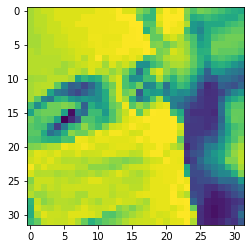

In [234]:
print(get_class(classes, labels[2000]))
plt.imshow(image_tensor[2000][0])

In [235]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(image_tensor, labels, test_size=0.3, stratify=labels, random_state=43)

In [236]:
print(X_train.shape)
print(X_test.shape)

torch.Size([2113, 1, 32, 32])
torch.Size([906, 1, 32, 32])


In [329]:
# Define CNN

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=1),
            
            
            # Defining another 2D convolution layer
            Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            ReLU(inplace=True),
            #MaxPool2d(kernel_size=2, stride=1),
            
            # Defining another 2D convolution layer
            Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            
            # Defining another 2D convolution layer
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            #Dropout(0.2),
        )

        self.linear_layers = Sequential(
            Linear(16 * 7 * 7, 4)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
        

In [330]:
devnet = Net()
summary(devnet, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 32, 32]              40
       BatchNorm2d-2            [-1, 4, 32, 32]               8
              ReLU-3            [-1, 4, 32, 32]               0
         MaxPool2d-4            [-1, 4, 31, 31]               0
            Conv2d-5            [-1, 8, 31, 31]             296
       BatchNorm2d-6            [-1, 8, 31, 31]              16
              ReLU-7            [-1, 8, 31, 31]               0
            Conv2d-8            [-1, 8, 31, 31]             584
       BatchNorm2d-9            [-1, 8, 31, 31]              16
             ReLU-10            [-1, 8, 31, 31]               0
        MaxPool2d-11            [-1, 8, 15, 15]               0
           Conv2d-12           [-1, 16, 15, 15]           1,168
      BatchNorm2d-13           [-1, 16, 15, 15]              32
             ReLU-14           [-1, 16,

In [331]:
# Defining optimizers and loss function
testmodel = Net()
adam_opt = Adam(testmodel.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

In [332]:
y_train.type()

'torch.FloatTensor'

In [333]:
labels.type()

'torch.FloatTensor'

In [334]:
# Training Loop

#torch.set_grad_enabled(True)
num_epochs = 70
train_losses = []
tr_loss = 0
testmodel.train()
for epoch in range(num_epochs):
    
    train_loss = 0
    
    adam_opt.zero_grad()
    
    output_train = testmodel(X_train)
    loss_train = criterion(output_train, y_train)
    train_losses.append(loss_train)
    
    loss_train.backward()
    adam_opt.step()
    
    if epoch%2 == 0:
        print("Epoch: {}      Loss: {}".format(epoch, loss_train))

Epoch: 0      Loss: 1.6100112199783325
Epoch: 2      Loss: 1.3883007764816284
Epoch: 4      Loss: 1.2584460973739624
Epoch: 6      Loss: 1.1324771642684937
Epoch: 8      Loss: 1.0974494218826294
Epoch: 10      Loss: 1.032745361328125
Epoch: 12      Loss: 0.9831207990646362
Epoch: 14      Loss: 0.9560291171073914
Epoch: 16      Loss: 0.9100276231765747
Epoch: 18      Loss: 0.86821049451828
Epoch: 20      Loss: 0.8413842916488647
Epoch: 22      Loss: 0.8063564300537109
Epoch: 24      Loss: 0.7738775610923767
Epoch: 26      Loss: 0.748898983001709
Epoch: 28      Loss: 0.719219982624054
Epoch: 30      Loss: 0.6937829852104187
Epoch: 32      Loss: 0.6709162592887878
Epoch: 34      Loss: 0.6470428705215454
Epoch: 36      Loss: 0.626684844493866
Epoch: 38      Loss: 0.6063060164451599
Epoch: 40      Loss: 0.5883417725563049
Epoch: 42      Loss: 0.5722825527191162
Epoch: 44      Loss: 0.5563051104545593
Epoch: 46      Loss: 0.5423711538314819
Epoch: 48      Loss: 0.528292179107666
Epoch: 50   

In [335]:
with torch.no_grad():
    test_out = testmodel(X_test)

pred = torch.argmax(test_out, 1)

In [336]:
accuracy_score(l, pred)

0.7847682119205298

In [339]:
con_matrix = confusion_matrix(l, pred)

In [342]:
con_matrix

array([[160,  19,  35,  15],
       [ 28, 104,  34,   5],
       [ 24,  27, 198,   0],
       [  2,   2,   4, 249]], dtype=int64)

In [359]:
# https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
df_cm = pd.DataFrame(con_matrix, index = [i for i in classes],
                     columns = [i for i in classes])

<AxesSubplot:>

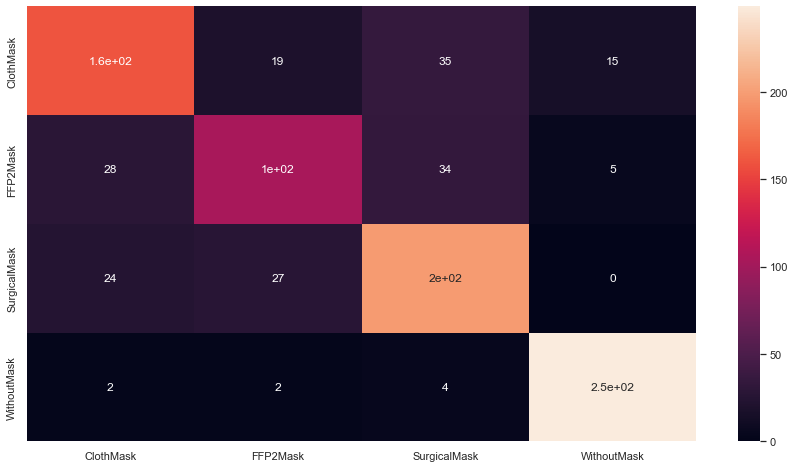

In [360]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df_cm, annot=True, )

In [366]:
#print(confusion_matrix(preds, labels))
tn, fp, fn, tp = confusion_matrix(l, pred)

accuracy = (tp+tn)/(tp+tn+fp+fn)
#print("accuracy:",accuracy)
score_accuracy = accuracy_score(pred, l)
print("score accuracy: ", score_accuracy)

precision = tp/(tp+fp)
#print("precision: ", precision)
score_precision = precision_score(pred, l, average='micro')
print("score precision",score_precision)

recall = tp/(tp+fn)
#print("recall: " ,recall)
score_recall = recall_score(pred, l, average='macro')
print("score recall: ", score_recall)

f1_measure = (2 * score_precision * score_recall)/(score_precision + score_recall)
print("f1 score: ", f1_measure)

score accuracy:  0.7847682119205298
score precision 0.7847682119205298
score recall:  0.7720379854028847
f1 score:  0.7783510502219372
